In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd  
import seaborn as sns 

%matplotlib inline

categories count:  [212 357]


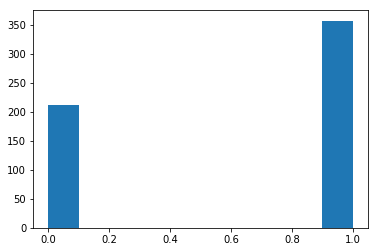

In [19]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
df = pd.DataFrame(
    data = np.concatenate([cancer.data, cancer.target.reshape(-1,1)], axis=1),
    columns = list(cancer.feature_names)+['target'] 
)
print("categories count: ", np.bincount(df['target']))
_ = plt.hist(cancer.target)

In [3]:
from sklearn.model_selection import train_test_split

X_tr, X_ts, y_tr, y_ts = train_test_split(
    df.drop('target', axis=1), df['target'],
    stratify=df['target'], test_size=0.3,
    random_state = 1234
)
X_train, y_train, X_valid, y_valid, X_test = X_tr, y_tr, X_ts, y_ts, X_ts

X_tr.shape, X_ts.shape, y_tr.shape, y_ts.shape

((398, 30), (171, 30), (398,), (171,))

In [4]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import classification_report as cr
import xgboost as xgb

import numpy as np
import pandas as pd
import gc

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR

from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC


def xgb_model(X_train, y_train, X_valid, y_valid, features, X_test, 
              num_round=10000, depth=4):
    param = {
        'eval_metric'     : 'auc',
        'seed'            : 1337,
        'eta'             : 0.05,
        'subsample'       : 0.7,
        'colsample_bytree': 0.5,
        'silent'          : 1,
        'nthread'         : 4,
        'Scale_pos_weight': 100,#3.607,
        'objective'       : 'binary:logistic',
        'max_depth'       : depth,
        'alpha'           : 0.09
    }
        
    _train = xgb.DMatrix(
        X_train[features], label=y_train, 
        feature_names=list(features)
    )
    _valid = xgb.DMatrix(
        X_valid[features], label=y_valid, 
        feature_names=list(features)
    )
    
    watchlist = [(_valid, 'valid')]
    clf = xgb.train(dtrain=_train, 
                    num_boost_round=num_round, 
                    evals=watchlist,
                    early_stopping_rounds=25, 
                    verbose_eval=0, 
                    params=param)
    
    valid_frame = xgb.DMatrix(X_valid[features],feature_names=list(features))
    oof  = clf.predict(valid_frame, ntree_limit=clf.best_ntree_limit)


    test_frame = xgb.DMatrix(X_test[features],feature_names=list(features))
    test_pred = clf.predict(test_frame, ntree_limit=clf.best_ntree_limit)
    
    return oof, test_pred


def passive_agg_model(X_train, y_train, X_valid, y_valid, X_test, 
                      alpha=1, balance='balanced'):

    clf = PassiveAggressiveClassifier(
            C=alpha, fit_intercept=True, max_iter=None, tol=None, 
#             early_stopping=False, validation_fraction=0.2, n_iter_no_change=5, 
            shuffle=True, verbose=0, n_jobs=-1, random_state=1234, loss='squared_hinge',
            class_weight=balance, average=False, n_iter=500)
    
    means = X_train.mean()
    clf.fit(X_train.fillna(means), y_train)
    oof  = clf.predict(X_valid.fillna(means))
    test_pred = clf.predict(X_test.fillna(means))

    return oof, test_pred

def logreg_model(X_train, y_train, X_valid, y_valid, X_test, 
                 alpha=500, balance='balanced'):
    
    clf = LogisticRegression(
            penalty='l2', dual=False, C=alpha, fit_intercept=True, 
            intercept_scaling=1, class_weight=balance, random_state=1234, 
            max_iter=100, verbose=0, n_jobs=-1)
    
    means = X_train.mean()
    clf.fit(X_train.fillna(means), y_train)
    oof  = clf.predict_proba(X_valid.fillna(means))[:,1]
    test_pred = clf.predict_proba(X_test.fillna(means))[:,1]

    return oof, test_pred

def ridge_model(X_train, y_train, X_valid, y_valid, X_test, 
                 alpha=0.01, balance='balanced'):
    
    clf = RidgeClassifier(
        alpha=alpha, fit_intercept=True, normalize=True, 
        class_weight=balance, random_state=1234)
    
    means = X_train.mean()
    clf.fit(X_train.fillna(means), y_train)
    oof  = clf.predict(X_valid.fillna(means))
    test_pred = clf.predict(X_test.fillna(means))

    return oof, test_pred
    
def stacking(train_df, target, test_df, split=4, depth=4, print_=False):

    n_splits = split
    random_seed = 1234
    
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    
    oof_xgb = np.zeros(len(train_df))
    oof_pas = np.zeros(len(train_df))
    oof_log = np.zeros(len(train_df))
    oof_rid = np.zeros(len(train_df))
    
    pred_xgb = np.zeros((len(test_df),n_splits))
    pred_pas = np.zeros((len(test_df),n_splits))
    pred_log = np.zeros((len(test_df),n_splits))
    pred_rid = np.zeros((len(test_df),n_splits))
    
    f1s = []
##########################
    for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):
        if print_: print("Fold {}".format(fold_), end=" \t\t")
    
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
        features = X_train.columns
#         if print_: print(X_train.shape, X_valid.shape)
        
        num_rounds = 10000
        
        # xgb model
        #################################
        oof, test_pred = xgb_model(
            X_train, y_train, 
            X_valid, y_valid, 
            features, test_df, 
            num_round=num_rounds,
            depth=depth
        )
        
        oof_xgb[valid_index] = oof
        pred_xgb[:,fold_] = test_pred
        
        y_bin = [1. if y_cont > 0.5 else 0. for y_cont in oof]
        xgb_score = f1_score(y_valid, y_bin, average='weighted')
#         if print_: print("="*60)
        f1s.append(xgb_score)
        ####################################
        
        # passive regressive
        #################################
        oof, test_pred = passive_agg_model(
            X_train, y_train, 
            X_valid, y_valid, 
            test_df, alpha=1
        )
        
        oof_pas[valid_index] = oof
        pred_pas[:,fold_] = test_pred
        
        y_bin = [1. if y_cont > 0.5 else 0. for y_cont in oof]
        pas_score = f1_score(y_valid, y_bin, average='weighted')
#         if print_: print("="*60)
        ####################################
        
        # logistic regression
        #################################
        oof, test_pred = logreg_model(
            X_train, y_train, 
            X_valid, y_valid, 
            test_df, alpha=1
        )
        
        oof_log[valid_index] = oof
        pred_log[:,fold_] = test_pred
        
        y_bin = [1. if y_cont > 0.5 else 0. for y_cont in oof]
        log_score = f1_score(y_valid, y_bin, average='weighted')
#         if print_: print("="*60)
        ####################################
        
        # ridge regression
        #################################
        oof, test_pred = ridge_model(
            X_train, y_train, 
            X_valid, y_valid, 
            test_df, alpha=1
        )
        
        oof_rid[valid_index] = oof
        pred_rid[:,fold_] = test_pred
        
        y_bin = [1. if y_cont > 0.5 else 0. for y_cont in oof]
        rid_score = f1_score(y_valid, y_bin, average='weighted')
        ####################################
        
        if print_:
            print("XGB: {:.3f} \t PASS-AGG: {:.3f} \t LOG-REG: {:.3f} \t RIDGE: {:.3f}".format(
                xgb_score, pas_score, log_score, rid_score
            ))
#             print(" xgb f1 = ", xgb_score )
#         if print_: print( " pass-agg f1 = ", pas_score )
#         if print_: print( " logreg f1 = ", log_score )
#         if print_: print( " ridge f1 = ", rid_score )
#             print("="*60)
        
    print("="*60)
    print( "  mean-f1 = ", np.mean(f1s))
    print("="*60)

    oofs = np.stack([oof_xgb, oof_pas, oof_log, oof_rid]).T
    preds = np.stack([pred_xgb.mean(1), pred_pas.mean(1), pred_log.mean(1), pred_rid.mean(1)]).T
    return oofs, preds

In [5]:
def classifier_model(clf_name, kernel='linear', degree=2, alpha=0.1):
    """
    clf_name = ['passive_agg', 'ridge', 'logistic', 'svm']
    """
    params = {'alpha':alpha}

    if clf_name == 'passive_agg':

        clf = PassiveAggressiveClassifier(
            C=params['alpha'], fit_intercept=True, max_iter=None, tol=None, 
#             early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, 
            shuffle=True, verbose=0, n_jobs=-1, random_state=1234, loss='hinge',
            class_weight='balanced', average=False, n_iter=100)

    elif clf_name is 'ridge':
        clf = RidgeClassifier(
            alpha=params['alpha'], fit_intercept=True, normalize=True, 
            class_weight='balanced', random_state=1234)

    elif clf_name is 'logistic':
        clf = LogisticRegression(
            penalty='l2', dual=False, C=params['alpha'], fit_intercept=True, 
            intercept_scaling=1, class_weight=None, random_state=1234, 
            max_iter=100, verbose=0, n_jobs=-1)

    elif clf_name is 'svm':
        kernel_func = kernel
        clf = SVC(
            C=params['alpha'], kernel=kernel_func, degree=degree, coef0=0.0, 
            shrinking=True, probability=False, tol=0.001, cache_size=200, 
            class_weight='balanced', verbose=False, max_iter=200, 
            decision_function_shape='ovr', random_state=1234)
    
    else:
        raise Exception('only [passive_agg, ridge, logistic, svm] are supported')
    
    return clf

In [6]:
# svc.predict_proba(X_valid)

In [7]:
print("passive \t logistic \t ridge \t\t svm")

clf = classifier_model('passive_agg')
clf.fit(X_train, y_train)
print(clf.score(X_valid, y_valid).round(3), end="\t\t")

clf = classifier_model('logistic')
clf.fit(X_train, y_train)
print(clf.score(X_valid, y_valid).round(3), end="\t\t")

clf = classifier_model('ridge')
clf.fit(X_train, y_train)
print(clf.score(X_valid, y_valid).round(3), end="\t\t")

clf = classifier_model('svm', kernel='linear', degree=2)
clf.fit(X_train, y_train)
print(clf.score(X_valid, y_valid).round(3))

for alpha in [0.01, 0.1, 1, 10, 20, 50, 100, 500, 1000]:
    pas = classifier_model('passive_agg', alpha=alpha)
    pas.fit(X_train, y_train)
    log = classifier_model('logistic', alpha=alpha)
    log.fit(X_train, y_train)
    rid = classifier_model('ridge', alpha=alpha)
    rid.fit(X_train, y_train)
    svc = classifier_model('svm', kernel='linear', degree=2, alpha=alpha)
    svc.fit(X_train, y_train)
    print("passive: {:.3f} :: logistic: {:.3f} :: ridge: {:.3f}  :: svm: {:.3f}".format(
        pas.score(X_valid, y_valid), log.score(X_valid, y_valid), 
        rid.score(X_valid, y_valid), svc.score(X_valid, y_valid)))

passive 	 logistic 	 ridge 		 svm
0.918		0.918		0.977		0.38
passive: 0.918 :: logistic: 0.924 :: ridge: 0.988  :: svm: 0.094
passive: 0.918 :: logistic: 0.918 :: ridge: 0.977  :: svm: 0.380
passive: 0.918 :: logistic: 0.953 :: ridge: 0.959  :: svm: 0.901
passive: 0.918 :: logistic: 0.971 :: ridge: 0.947  :: svm: 0.901
passive: 0.918 :: logistic: 0.971 :: ridge: 0.947  :: svm: 0.901
passive: 0.918 :: logistic: 0.982 :: ridge: 0.942  :: svm: 0.901
passive: 0.918 :: logistic: 0.977 :: ridge: 0.942  :: svm: 0.901
passive: 0.918 :: logistic: 0.982 :: ridge: 0.942  :: svm: 0.901
passive: 0.918 :: logistic: 0.977 :: ridge: 0.942  :: svm: 0.901


In [8]:
oofs, preds = stacking(X_train, y_train, X_valid, split=10, depth=5, print_=True)

Fold 0 		XGB: 0.975 	 PASS-AGG: 0.902 	 LOG-REG: 1.000 	 RIDGE: 1.000
Fold 1 		XGB: 0.949 	 PASS-AGG: 0.925 	 LOG-REG: 0.975 	 RIDGE: 0.975
Fold 2 		XGB: 0.951 	 PASS-AGG: 0.925 	 LOG-REG: 0.925 	 RIDGE: 0.975
Fold 3 		XGB: 1.000 	 PASS-AGG: 0.975 	 LOG-REG: 0.975 	 RIDGE: 0.949
Fold 4 		XGB: 0.975 	 PASS-AGG: 0.901 	 LOG-REG: 0.951 	 RIDGE: 1.000
Fold 5 		XGB: 0.872 	 PASS-AGG: 0.868 	 LOG-REG: 0.896 	 RIDGE: 0.809
Fold 6 		XGB: 0.926 	 PASS-AGG: 0.827 	 LOG-REG: 0.900 	 RIDGE: 0.975
Fold 7 		XGB: 1.000 	 PASS-AGG: 0.876 	 LOG-REG: 0.925 	 RIDGE: 1.000
Fold 8 		XGB: 0.868 	 PASS-AGG: 0.382 	 LOG-REG: 0.922 	 RIDGE: 0.839
Fold 9 		XGB: 0.948 	 PASS-AGG: 0.864 	 LOG-REG: 0.974 	 RIDGE: 1.000
  mean-f1 =  0.9462730376674978


In [9]:
oofs.shape, preds.shape, X_train.shape, X_test.shape

((398, 4), (171, 4), (398, 30), (171, 30))

In [10]:
print("passive \t logistic \t ridge \t\t svm")

clf = classifier_model('passive_agg')
clf.fit(X_train, y_train)
print(clf.score(X_valid, y_valid).round(3), end="\t\t")

clf = classifier_model('logistic')
clf.fit(X_train, y_train)
print(clf.score(X_valid, y_valid).round(3), end="\t\t")

clf = classifier_model('ridge')
clf.fit(X_train, y_train)
print(clf.score(X_valid, y_valid).round(3), end="\t\t")

clf = classifier_model('svm', kernel='linear', degree=2)
clf.fit(X_train, y_train)
print(clf.score(X_valid, y_valid).round(3))

for alpha in [0.01, 0.1, 1, 10, 20, 50, 100, 500, 1000]:
    pas = classifier_model('passive_agg', alpha=alpha)
    pas.fit(X_train, y_train)
    log = classifier_model('logistic', alpha=alpha)
    log.fit(X_train, y_train)
    rid = classifier_model('ridge', alpha=alpha)
    rid.fit(X_train, y_train)
    svc = classifier_model('svm', kernel='linear', degree=2, alpha=alpha)
    svc.fit(X_train, y_train)
    print("passive: {:.3f} :: logistic: {:.3f} :: ridge: {:.3f}  :: svm: {:.3f}".format(
        pas.score(X_valid, y_valid), log.score(X_valid, y_valid), 
        rid.score(X_valid, y_valid), svc.score(X_valid, y_valid)))

passive 	 logistic 	 ridge 		 svm
0.918		0.918		0.977		0.38
passive: 0.918 :: logistic: 0.924 :: ridge: 0.988  :: svm: 0.094
passive: 0.918 :: logistic: 0.918 :: ridge: 0.977  :: svm: 0.380
passive: 0.918 :: logistic: 0.953 :: ridge: 0.959  :: svm: 0.901
passive: 0.918 :: logistic: 0.971 :: ridge: 0.947  :: svm: 0.901
passive: 0.918 :: logistic: 0.971 :: ridge: 0.947  :: svm: 0.901
passive: 0.918 :: logistic: 0.982 :: ridge: 0.942  :: svm: 0.901
passive: 0.918 :: logistic: 0.977 :: ridge: 0.942  :: svm: 0.901
passive: 0.918 :: logistic: 0.982 :: ridge: 0.942  :: svm: 0.901
passive: 0.918 :: logistic: 0.977 :: ridge: 0.942  :: svm: 0.901


In [11]:
oofs1 = oofs.copy()
preds1 = preds.copy()

In [12]:
for alpha in [0.01, 0.1, 1, 10, 20, 50, 100, 500, 1000]:
    pas = classifier_model('passive_agg', alpha=alpha)
    pas.fit(oofs, y_train)
    log = classifier_model('logistic', alpha=alpha)
    log.fit(oofs, y_train)
    rid = classifier_model('ridge', alpha=alpha)
    rid.fit(oofs, y_train)
    svc = classifier_model('svm', kernel='linear', degree=2, alpha=alpha)
    svc.fit(oofs, y_train)
    print("passive: {:.3f} :: logistic: {:.3f} :: ridge: {:.3f}  :: svm: {:.3f}".format(
        pas.score(preds, y_valid), log.score(preds, y_valid), 
        rid.score(preds, y_valid), svc.score(preds, y_valid)))

passive: 0.965 :: logistic: 0.906 :: ridge: 0.971  :: svm: 0.982
passive: 0.965 :: logistic: 0.959 :: ridge: 0.982  :: svm: 0.965
passive: 0.953 :: logistic: 0.982 :: ridge: 0.982  :: svm: 0.965
passive: 0.959 :: logistic: 0.982 :: ridge: 0.982  :: svm: 0.965
passive: 0.959 :: logistic: 0.982 :: ridge: 0.982  :: svm: 0.965
passive: 0.959 :: logistic: 0.982 :: ridge: 0.982  :: svm: 0.965
passive: 0.959 :: logistic: 0.982 :: ridge: 0.982  :: svm: 0.965
passive: 0.959 :: logistic: 0.982 :: ridge: 0.982  :: svm: 0.965
passive: 0.953 :: logistic: 0.982 :: ridge: 0.982  :: svm: 0.965


In [6]:
df.shape

(569, 31)

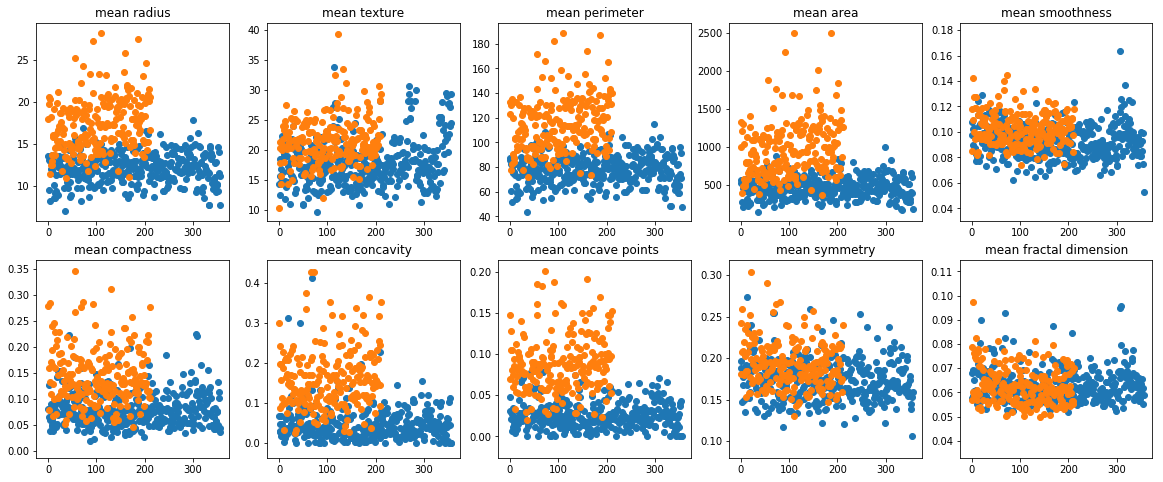

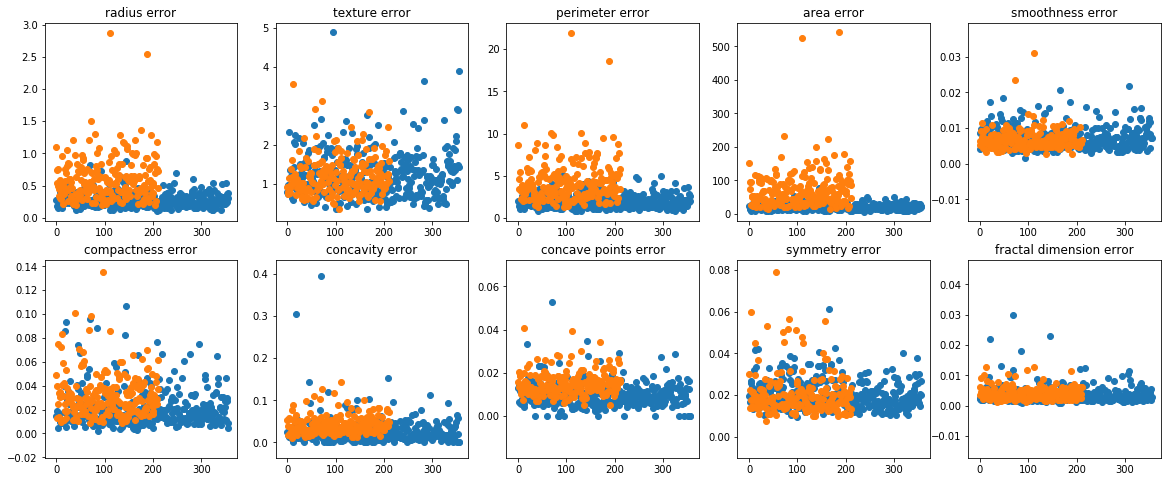

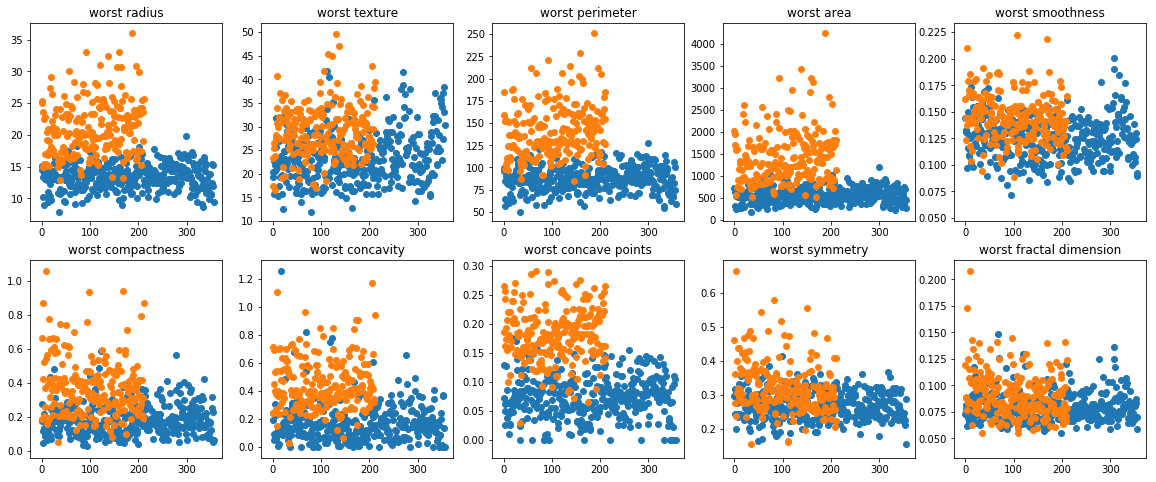

In [8]:

pos = df[df['target'] == 1]
neg = df[df['target'] == 0]
   
fig, ax = plt.subplots(2,5,figsize=(20,8))
axes = ax.flatten()
for i, col in enumerate(df.columns[:10]):
    try:
        axes[i].scatter(range(len(pos)), pos[col])#, 'r', label='1')
        axes[i].scatter(range(len(neg)), neg[col])#, 'b', label='0')
        axes[i].set_title(col)
    except:
        pass
plt.show()    

fig, ax = plt.subplots(2,5,figsize=(20,8))
axes = ax.flatten()
for i, col in enumerate(df.columns[10:20]):
    try:
        axes[i].scatter(range(len(pos)), pos[col])#, 'r', label='1')
        axes[i].scatter(range(len(neg)), neg[col])#, 'b', label='0')
        axes[i].set_title(col)
    except:
        pass
plt.show()    

fig, ax = plt.subplots(2,5,figsize=(20,8))
axes = ax.flatten()
for i, col in enumerate(df.columns[20:30]):
    try:
        axes[i].scatter(range(len(pos)), pos[col])#, 'r', label='1')
        axes[i].scatter(range(len(neg)), neg[col])#, 'b', label='0')
        axes[i].set_title(col)
    except:
        pass
plt.show()

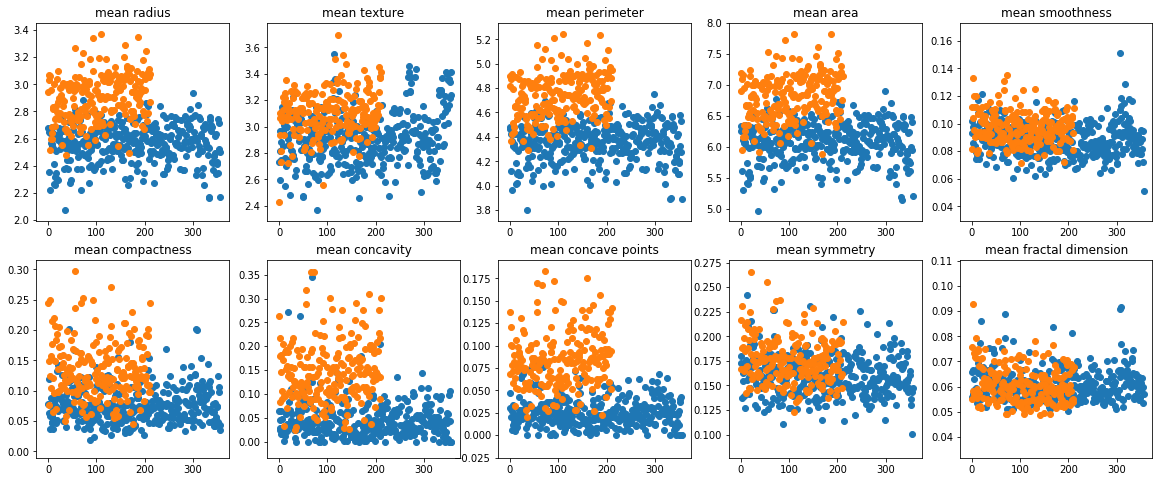

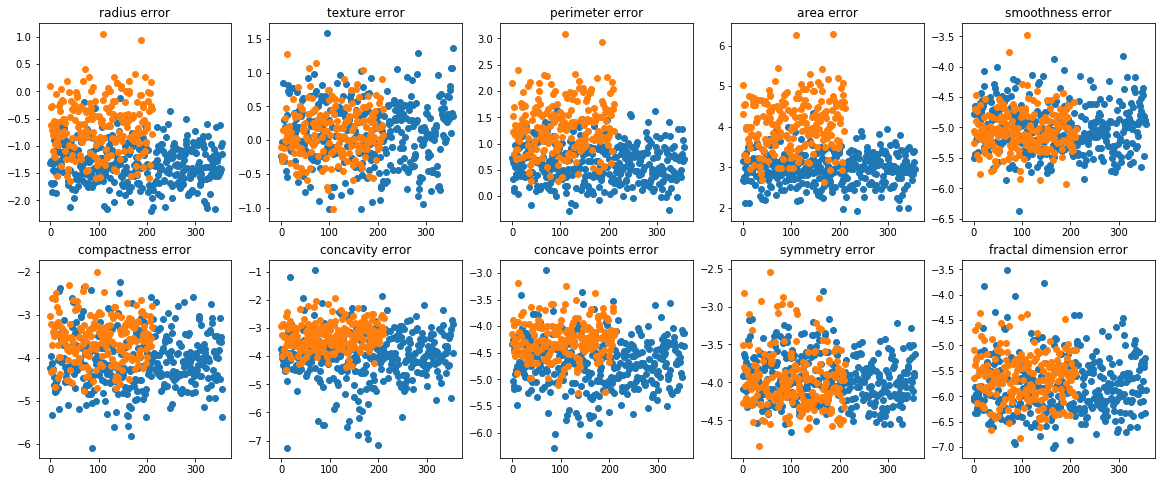

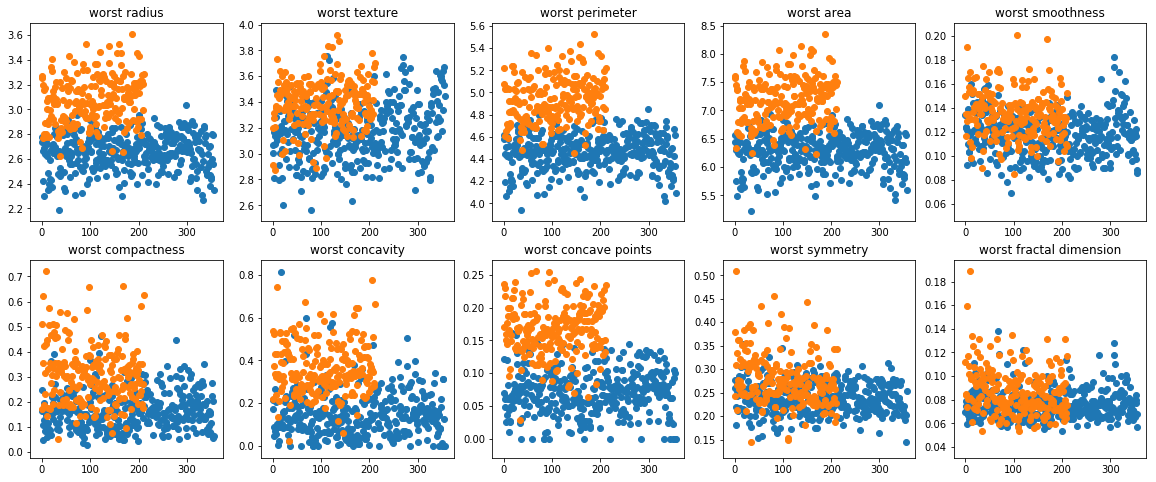

In [15]:

pos = df[df['target'] == 1]
neg = df[df['target'] == 0]
   
fig, ax = plt.subplots(2,5,figsize=(20,8))
axes = ax.flatten()
for i, col in enumerate(df.columns[:10]):
    try:
        axes[i].scatter(range(len(pos)), np.log(1+pos[col]))#, 'r', label='1')
        axes[i].scatter(range(len(neg)), np.log(1+neg[col]))#, 'b', label='0')
        axes[i].set_title(col)
    except:
        pass
plt.show()    

fig, ax = plt.subplots(2,5,figsize=(20,8))
axes = ax.flatten()
for i, col in enumerate(df.columns[10:20]):
    try:
        axes[i].scatter(range(len(pos)), np.log(pos[col]))#, 'r', label='1')
        axes[i].scatter(range(len(neg)), np.log(neg[col]))#, 'b', label='0')
        axes[i].set_title(col)
    except:
        pass
plt.show()    

fig, ax = plt.subplots(2,5,figsize=(20,8))
axes = ax.flatten()
for i, col in enumerate(df.columns[20:30]):
    try:
        axes[i].scatter(range(len(pos)), np.log(1+pos[col]))#, 'r', label='1')
        axes[i].scatter(range(len(neg)), np.log(1+neg[col]))#, 'b', label='0')
        axes[i].set_title(col)
    except:
        pass
plt.show()

In [25]:
for col in df.columns[10:20]:
    print(np.min(np.log(1e-5+df[col])), np.max(np.log(1e-5+df[col])))
    

-2.193641006004867 1.0553602606733088
-1.0210680842714006 1.5861713325755575
-0.27837881559231004 3.0901334039344257
1.9172181567397595 6.295634955507944
-6.363688321436345 -3.469262112576285
-6.091505901288208 -1.9994480659874043
-11.512925464970229 -0.9263158155212435
-11.512925464970229 -2.9412440882699213
-4.841905690821768 -2.538813883856911
-7.007796633162363 -3.511570439143526


In [26]:
for col in df.columns[10:20]:
    df[col] = np.log(1e-5+df[col])
    
    
from sklearn.model_selection import train_test_split

X_tr, X_ts, y_tr, y_ts = train_test_split(
    df.drop('target', axis=1), df['target'],
    stratify=df['target'], test_size=0.3,
    random_state = 1234
)
X_train, y_train, X_valid, y_valid, X_test = X_tr, y_tr, X_ts, y_ts, X_ts

X_tr.shape, X_ts.shape, y_tr.shape, y_ts.shape

((398, 30), (171, 30), (398,), (171,))

In [27]:
print("passive \t logistic \t ridge \t\t svm")

clf = classifier_model('passive_agg')
clf.fit(X_train, y_train)
print(clf.score(X_valid, y_valid).round(3), end="\t\t")

clf = classifier_model('logistic')
clf.fit(X_train, y_train)
print(clf.score(X_valid, y_valid).round(3), end="\t\t")

clf = classifier_model('ridge')
clf.fit(X_train, y_train)
print(clf.score(X_valid, y_valid).round(3), end="\t\t")

clf = classifier_model('svm', kernel='linear', degree=2)
clf.fit(X_train, y_train)
print(clf.score(X_valid, y_valid).round(3))

for alpha in [0.01, 0.1, 1, 10, 20, 50, 100, 500, 1000]:
    pas = classifier_model('passive_agg', alpha=alpha)
    pas.fit(X_train, y_train)
    log = classifier_model('logistic', alpha=alpha)
    log.fit(X_train, y_train)
    rid = classifier_model('ridge', alpha=alpha)
    rid.fit(X_train, y_train)
    svc = classifier_model('svm', kernel='linear', degree=2, alpha=alpha)
    svc.fit(X_train, y_train)
    print("passive: {:.3f} :: logistic: {:.3f} :: ridge: {:.3f}  :: svm: {:.3f}".format(
        pas.score(X_valid, y_valid), log.score(X_valid, y_valid), 
        rid.score(X_valid, y_valid), svc.score(X_valid, y_valid)))

passive 	 logistic 	 ridge 		 svm
0.912		0.942		0.971		0.626
passive: 0.912 :: logistic: 0.918 :: ridge: 0.977  :: svm: 0.936
passive: 0.912 :: logistic: 0.942 :: ridge: 0.971  :: svm: 0.626
passive: 0.912 :: logistic: 0.965 :: ridge: 0.959  :: svm: 0.930
passive: 0.912 :: logistic: 0.953 :: ridge: 0.947  :: svm: 0.930
passive: 0.912 :: logistic: 0.953 :: ridge: 0.947  :: svm: 0.930
passive: 0.912 :: logistic: 0.947 :: ridge: 0.947  :: svm: 0.930
passive: 0.912 :: logistic: 0.947 :: ridge: 0.947  :: svm: 0.930
passive: 0.912 :: logistic: 0.947 :: ridge: 0.947  :: svm: 0.930
passive: 0.912 :: logistic: 0.947 :: ridge: 0.947  :: svm: 0.930


In [ ]:

# passive 	 logistic 	 ridge 		 svm
# 0.918		0.918		0.977		0.38
# passive: 0.918 :: logistic: 0.924 :: ridge: 0.988  :: svm: 0.094
# passive: 0.918 :: logistic: 0.918 :: ridge: 0.977  :: svm: 0.380
# passive: 0.918 :: logistic: 0.953 :: ridge: 0.959  :: svm: 0.901
# passive: 0.918 :: logistic: 0.971 :: ridge: 0.947  :: svm: 0.901
# passive: 0.918 :: logistic: 0.971 :: ridge: 0.947  :: svm: 0.901
# passive: 0.918 :: logistic: 0.982 :: ridge: 0.942  :: svm: 0.901
# passive: 0.918 :: logistic: 0.977 :: ridge: 0.942  :: svm: 0.901
# passive: 0.918 :: logistic: 0.982 :: ridge: 0.942  :: svm: 0.901
# passive: 0.918 :: logistic: 0.977 :: ridge: 0.942  :: svm: 0.901

In [28]:
oofs, preds = stacking(X_train, y_train, X_valid, split=10, depth=5, print_=True)

Fold 0 		XGB: 0.975 	 PASS-AGG: 0.902 	 LOG-REG: 1.000 	 RIDGE: 1.000
Fold 1 		XGB: 0.949 	 PASS-AGG: 0.950 	 LOG-REG: 1.000 	 RIDGE: 1.000
Fold 2 		XGB: 0.951 	 PASS-AGG: 0.975 	 LOG-REG: 0.925 	 RIDGE: 0.975
Fold 3 		XGB: 1.000 	 PASS-AGG: 0.975 	 LOG-REG: 1.000 	 RIDGE: 0.975
Fold 4 		XGB: 0.975 	 PASS-AGG: 0.926 	 LOG-REG: 1.000 	 RIDGE: 1.000
Fold 5 		XGB: 0.872 	 PASS-AGG: 0.839 	 LOG-REG: 0.949 	 RIDGE: 0.809
Fold 6 		XGB: 0.926 	 PASS-AGG: 0.852 	 LOG-REG: 0.901 	 RIDGE: 0.975
Fold 7 		XGB: 1.000 	 PASS-AGG: 0.876 	 LOG-REG: 0.951 	 RIDGE: 1.000
Fold 8 		XGB: 0.868 	 PASS-AGG: 0.338 	 LOG-REG: 0.922 	 RIDGE: 0.864
Fold 9 		XGB: 0.948 	 PASS-AGG: 0.864 	 LOG-REG: 0.974 	 RIDGE: 0.974
  mean-f1 =  0.9462730376674978


In [ ]:
# oofs, preds = stacking(X_train, y_train, X_valid, split=10, depth=5, print_=True)

# Fold 0 		XGB: 0.975 	 PASS-AGG: 0.902 	 LOG-REG: 1.000 	 RIDGE: 1.000
# Fold 1 		XGB: 0.949 	 PASS-AGG: 0.925 	 LOG-REG: 0.975 	 RIDGE: 0.975
# Fold 2 		XGB: 0.951 	 PASS-AGG: 0.925 	 LOG-REG: 0.925 	 RIDGE: 0.975
# Fold 3 		XGB: 1.000 	 PASS-AGG: 0.975 	 LOG-REG: 0.975 	 RIDGE: 0.949
# Fold 4 		XGB: 0.975 	 PASS-AGG: 0.901 	 LOG-REG: 0.951 	 RIDGE: 1.000
# Fold 5 		XGB: 0.872 	 PASS-AGG: 0.868 	 LOG-REG: 0.896 	 RIDGE: 0.809
# Fold 6 		XGB: 0.926 	 PASS-AGG: 0.827 	 LOG-REG: 0.900 	 RIDGE: 0.975
# Fold 7 		XGB: 1.000 	 PASS-AGG: 0.876 	 LOG-REG: 0.925 	 RIDGE: 1.000
# Fold 8 		XGB: 0.868 	 PASS-AGG: 0.382 	 LOG-REG: 0.922 	 RIDGE: 0.839
# Fold 9 		XGB: 0.948 	 PASS-AGG: 0.864 	 LOG-REG: 0.974 	 RIDGE: 1.000
# ============================================================
#   mean-f1 =  0.9462730376674978
# ============================================================


In [29]:
for alpha in [0.01, 0.1, 1, 10, 20, 50, 100, 500, 1000]:
    pas = classifier_model('passive_agg', alpha=alpha)
    pas.fit(oofs, y_train)
    log = classifier_model('logistic', alpha=alpha)
    log.fit(oofs, y_train)
    rid = classifier_model('ridge', alpha=alpha)
    rid.fit(oofs, y_train)
    svc = classifier_model('svm', kernel='linear', degree=2, alpha=alpha)
    svc.fit(oofs, y_train)
    print("passive: {:.3f} :: logistic: {:.3f} :: ridge: {:.3f}  :: svm: {:.3f}".format(
        pas.score(preds, y_valid), log.score(preds, y_valid), 
        rid.score(preds, y_valid), svc.score(preds, y_valid)))

passive: 0.959 :: logistic: 0.906 :: ridge: 0.965  :: svm: 0.977
passive: 0.959 :: logistic: 0.959 :: ridge: 0.971  :: svm: 0.977
passive: 0.959 :: logistic: 0.971 :: ridge: 0.988  :: svm: 0.965
passive: 0.953 :: logistic: 0.971 :: ridge: 0.988  :: svm: 0.959
passive: 0.953 :: logistic: 0.971 :: ridge: 0.988  :: svm: 0.959
passive: 0.942 :: logistic: 0.971 :: ridge: 0.988  :: svm: 0.959
passive: 0.942 :: logistic: 0.971 :: ridge: 0.988  :: svm: 0.959
passive: 0.942 :: logistic: 0.971 :: ridge: 0.988  :: svm: 0.982
passive: 0.942 :: logistic: 0.971 :: ridge: 0.988  :: svm: 0.959


In [ ]:
# passive: 0.965 :: logistic: 0.906 :: ridge: 0.971  :: svm: 0.982
# passive: 0.965 :: logistic: 0.959 :: ridge: 0.982  :: svm: 0.965
# passive: 0.953 :: logistic: 0.982 :: ridge: 0.982  :: svm: 0.965
# passive: 0.959 :: logistic: 0.982 :: ridge: 0.982  :: svm: 0.965
# passive: 0.959 :: logistic: 0.982 :: ridge: 0.982  :: svm: 0.965
# passive: 0.959 :: logistic: 0.982 :: ridge: 0.982  :: svm: 0.965
# passive: 0.959 :: logistic: 0.982 :: ridge: 0.982  :: svm: 0.965
# passive: 0.959 :: logistic: 0.982 :: ridge: 0.982  :: svm: 0.965
# passive: 0.953 :: logistic: 0.982 :: ridge: 0.982  :: svm: 0.965

In [30]:
X_train.shape

(398, 30)

In [31]:
oofs, preds = stacking(X_train, y_train, X_valid, split=6, depth=5, print_=True)

Fold 0 		XGB: 0.970 	 PASS-AGG: 0.955 	 LOG-REG: 0.985 	 RIDGE: 1.000
Fold 1 		XGB: 0.985 	 PASS-AGG: 0.591 	 LOG-REG: 0.955 	 RIDGE: 0.970
Fold 2 		XGB: 0.956 	 PASS-AGG: 0.955 	 LOG-REG: 1.000 	 RIDGE: 1.000
Fold 3 		XGB: 0.894 	 PASS-AGG: 0.876 	 LOG-REG: 0.909 	 RIDGE: 0.893
Fold 4 		XGB: 0.909 	 PASS-AGG: 0.906 	 LOG-REG: 0.939 	 RIDGE: 1.000
Fold 5 		XGB: 0.937 	 PASS-AGG: 0.849 	 LOG-REG: 0.921 	 RIDGE: 0.904
  mean-f1 =  0.941771330927133


In [32]:
for alpha in [0.01, 0.1, 1, 10, 20, 50, 100, 500, 1000]:
    pas = classifier_model('passive_agg', alpha=alpha)
    pas.fit(oofs, y_train)
    log = classifier_model('logistic', alpha=alpha)
    log.fit(oofs, y_train)
    rid = classifier_model('ridge', alpha=alpha)
    rid.fit(oofs, y_train)
    svc = classifier_model('svm', kernel='linear', degree=2, alpha=alpha)
    svc.fit(oofs, y_train)
    print("passive: {:.3f} :: logistic: {:.3f} :: ridge: {:.3f}  :: svm: {:.3f}".format(
        pas.score(preds, y_valid), log.score(preds, y_valid), 
        rid.score(preds, y_valid), svc.score(preds, y_valid)))

passive: 0.965 :: logistic: 0.918 :: ridge: 0.977  :: svm: 0.982
passive: 0.965 :: logistic: 0.959 :: ridge: 0.982  :: svm: 0.965
passive: 0.959 :: logistic: 0.977 :: ridge: 0.988  :: svm: 0.965
passive: 0.959 :: logistic: 0.982 :: ridge: 0.988  :: svm: 0.965
passive: 0.959 :: logistic: 0.977 :: ridge: 0.988  :: svm: 0.965
passive: 0.959 :: logistic: 0.982 :: ridge: 0.988  :: svm: 0.965
passive: 0.959 :: logistic: 0.982 :: ridge: 0.988  :: svm: 0.965
passive: 0.959 :: logistic: 0.982 :: ridge: 0.988  :: svm: 0.965
passive: 0.959 :: logistic: 0.988 :: ridge: 0.988  :: svm: 0.363
